An encoder-decoder network can be trained to generate the contents of an arbitrary image region conditioned on its surroundings. The model can only suceed at this task if it both understands the content of the entire image, as well as produces a plausible hypothesis for the missing parts.

The self-supervision in the form of context inpainting is obtained with no cost and is very effective in learning useful representations.

Download the part_labels dataset. 5,000 images are used for pre-training the network for context inpainting task which can later be used for face parsing.

Run using google colab.

In [0]:
!wget -nc --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1KliNy-Jx-_ZaK12pm8BA2qKAJOt0483_' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1KliNy-Jx-_ZaK12pm8BA2qKAJOt0483_" -O part_labels.zip && rm -rf /tmp/cookies.txt

--2019-08-05 11:09:53--  https://docs.google.com/uc?export=download&confirm=wHXI&id=1KliNy-Jx-_ZaK12pm8BA2qKAJOt0483_
Resolving docs.google.com (docs.google.com)... 74.125.142.102, 74.125.142.101, 74.125.142.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.142.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-74-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5uba9fv0pfekntr7n2l7ep7qnnmp777m/1564999200000/10570413806168058073/*/1KliNy-Jx-_ZaK12pm8BA2qKAJOt0483_?e=download [following]
--2019-08-05 11:09:53--  https://doc-04-74-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5uba9fv0pfekntr7n2l7ep7qnnmp777m/1564999200000/10570413806168058073/*/1KliNy-Jx-_ZaK12pm8BA2qKAJOt0483_?e=download
Resolving doc-04-74-docs.googleusercontent.com (doc-04-74-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to doc-04-74-docs.googleusercontent.com

In [0]:
!unzip part_labels.zip

Download the helper modules from this github [link](https://github.com/tumble-weed/suriya-self-supervised).

In [0]:
!git clone https://github.com/tumble-weed/suriya-self-supervised.git
!mv suriya-self-supervised/*.py .
!rm -rf suriya-self-supervised

Cloning into 'suriya-self-supervised'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), done.


In [0]:
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn

from enc_dec import encoder_decoder
from utils import *
import matplotlib.pyplot as plt
DATA_ROOT = './'

In [0]:
import os.path as osp

import numpy as np
import cv2
import torch
from torch.utils import data
from random import shuffle
import os.path
import os
import copy
import math

In [0]:
train_img_root = DATA_ROOT + 'part_labels/data/all/'
train_image_list = DATA_ROOT + 'part_labels/splits/train_unlabeled_5k.txt'

val_img_root = DATA_ROOT + 'part_labels/data/all/'
val_image_list = DATA_ROOT + 'part_labels/splits/val_unlabeled_500.txt'

In [0]:
class ContextInpaintingDataset(data.Dataset):
    
    def __init__(self, img_root, image_list, mirror = True, 
        context_shape = [32, 32], context_count = 4, split = 'train'):

        self.img_root = img_root
        self.split = split
        self.image_list = [line.rstrip('\n') for line in open(image_list)]

        self.mirror = mirror
        self.context_shape = context_shape
        self.context_count = context_count

        self.mean_bgr = np.array([104.00698793, 116.66876762, 122.67891434]) # because we are reading using cv2
        self.std_bgr = 255*np.array([0.229, 0.224, 0.225])


        self.files = {}
        if self.split not in self.files.keys():
            self.files[self.split] = []
        for f in self.image_list:

            self.files[self.split].append({'img': img_root+f, 'lbl': 0})
        
    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        image_file_name = self.img_root + self.image_list[index]
        
        image = None
        if os.path.isfile(image_file_name):
            image = cv2.imread(image_file_name)
        else:
            print('ERROR: couldn\'t find image -> ', image_file_name)
            
        if self.mirror: # randomly flip the image
            flip = torch.LongTensor(1).random_(0, 2)[0]*2-1 # complicated way of either -1, 1
            image = image[:, ::flip, :]

        ''' '''
        context_shape = self.context_shape
        context_mask = np.zeros((3, image.shape[0], image.shape[1]), np.uint8)

        ''' '''
        if self.context_count == 1:
            left = image.shape[0]/2 - context_shape[0]/2 #left of center patch
            context_mask[:, left:left+context_shape[0], left:left+context_shape[1]] = 1 # mask is made up ones
            image[left:left+context_shape[0], left:left+context_shape[1], 0] = self.mean_bgr[0] # put in mean values in this center
            image[left:left+context_shape[0], left:left+context_shape[1], 1] = self.mean_bgr[1] # put in mean values in this center
            image[left:left+context_shape[0], left:left+context_shape[1], 2] = self.mean_bgr[2] # put in mean values in this center

        else:
            orig_image = copy.deepcopy(image)
            for c_ in range(self.context_count):
                row = torch.LongTensor(1).random_(0, image.shape[0]-context_shape[0]-1)[0] # all valid locations for the left corner
                col = torch.LongTensor(1).random_(0, image.shape[1]-context_shape[1]-1)[0] # all valid locations for the left corner
                context_mask[:, row:row+context_shape[0], col:col+context_shape[1]] = 1
                image[row:row+context_shape[0], col:col+context_shape[1], 0] = self.mean_bgr[0]
                image[row:row+context_shape[0], col:col+context_shape[1], 1] = self.mean_bgr[1]
                image[row:row+context_shape[0], col:col+context_shape[1], 2] = self.mean_bgr[2]


        return self.transform_image(image), self.transform_mask(context_mask), self.transform_context(orig_image)

    def transform_image(self, image):
        # normalize the image by subtracting mean
        # why no need to divide by deviation?
        image = image.astype(np.float64)
        image -= self.mean_bgr
        image = image.transpose(2, 0, 1) # torch tensors are (batch,channel,row,col)
        image = torch.from_numpy(image.copy()).float() 

        return image

    def transform_mask(self, mask):
        
        mask = torch.from_numpy(mask.copy()).float() # convert to tensor

        return mask

    def transform_context(self, context):
        # normalize the context by subtracting mean
        # divide standard deviation
        
        context = context.astype(np.float64)
        context -= self.mean_bgr
        context[:,:,0] /= 3*self.std_bgr[0]
        context[:,:,1] /= 3*self.std_bgr[1]
        context[:,:,2] /= 3*self.std_bgr[2]


        context[context>1] = 1 # limit values to -1 to 1
        context[context<-1] = -1

        context = context.transpose(2, 0, 1) 
        context = torch.from_numpy(context.copy()).float()

        return context

In [0]:
train_loader = torch.utils.data.DataLoader(ContextInpaintingDataset(img_root = train_img_root,
                                                                  image_list = train_image_list, mirror = True),
                                           batch_size=16, num_workers=2, shuffle = True, pin_memory=False)

val_loader = torch.utils.data.DataLoader(ContextInpaintingDataset(img_root = val_img_root,
                                                                  image_list = val_image_list, mirror = True,split='val'),
                                           batch_size=16, num_workers=2, shuffle = False, pin_memory=False)

An encoder-decoder architecture with 4 convolution layers each is sued. Each convolution layer (except the last layer) is followed by BatchNorm and ReLU. The context inpainting technique is used to pre-train the encoder and the decoder in a self-supervised way.

In [0]:
net = encoder_decoder().cuda()
tanh = nn.Tanh() # to make the output within (-1 to 1)
experiment = 'image inpainting'

In [0]:
print('Net params (M): ', param_counts(net)/(1000000.0))

Net params (M):  0.121251


In [0]:
use_cuda = torch.cuda.is_available()
best_loss = 9999  # best test accuracy

In [0]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones = [30,40], gamma=0.1, last_epoch=-1) # learning rate starts from 0.1, 0.01 from 30, 0.001 from 40
trends = {'train_loss':[],
         'val_loss':[]}
for epoch in range(0, 50):
    
    '''
    Train
    '''
    
    print('\nTrain epoch: %d' % epoch)
    net.train()
    train_loss = 0
    for batch_idx, (inputs, masks, contexts) in enumerate(train_loader):
        if use_cuda:
            inputs, masks, contexts = inputs.cuda(), masks.cuda(), contexts.cuda()
        optimizer.zero_grad()
#         inputs = Variable(inputs)
#         masks = Variable(masks)
#         contexts = Variable(contexts)
        outputs = tanh(net(inputs))
        
        # no adversarial loss (for this experiment)
        # look closely at the masked regions
        # and less importance is given to the rest of the image (to keep the results smooth)
        loss = 0.99*torch.mean(torch.mul((outputs - contexts)**2, masks)) \
        + 0.01*torch.mean(torch.mul((outputs - contexts)**2, 1-masks))
        
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
   
    train_loss = (train_loss/(batch_idx+1))
    print('Loss: %f '% train_loss)
    
    '''
    Val
    '''
    print('\nVal epoch: %d' % epoch)
    net.eval()
    val_loss = 0
    for batch_idx, (inputs, masks, contexts) in enumerate(val_loader):
        if use_cuda:
            inputs, masks, contexts = inputs.cuda(), masks.cuda(), contexts.cuda()
#         inputs = Variable(inputs)
#         masks = Variable(masks)
#         contexts = Variable(contexts)
        outputs = tanh(net(inputs))
        loss = 0.99*torch.mean(torch.mul((outputs - contexts)**2, masks)) + 0.01*torch.mean(torch.mul((outputs - contexts)**2, 1-masks))
        val_loss += loss.item()
    val_loss = (val_loss/(batch_idx+1))
    print('Loss: %f '% val_loss)
    # Save checkpoint.
    if val_loss < best_loss:
        print('Saving..')
        state = {'net': net}
        if not os.path.isdir(DATA_ROOT + 'checkpoint'):
            os.mkdir(DATA_ROOT + 'checkpoint')
        torch.save(state, DATA_ROOT + 'checkpoint/'+experiment+'ckpt.t7')
        best_loss = val_loss
    trends['train_loss'].append(train_loss)
    trends['val_loss'].append(val_loss)
    '''
    lr scheduler step
    '''
    lr_scheduler.step()


Train epoch: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Loss: 0.006495 

Val epoch: 0
Loss: 0.004398 
Saving..

Train epoch: 1
Loss: 0.004161 

Val epoch: 1
Loss: 0.003627 
Saving..

Train epoch: 2
Loss: 0.003680 

Val epoch: 2
Loss: 0.003333 
Saving..

Train epoch: 3
Loss: 0.003385 

Val epoch: 3
Loss: 0.003019 
Saving..

Train epoch: 4
Loss: 0.003190 

Val epoch: 4
Loss: 0.003191 

Train epoch: 5
Loss: 0.003030 

Val epoch: 5
Loss: 0.002812 
Saving..

Train epoch: 6
Loss: 0.002896 

Val epoch: 6
Loss: 0.002696 
Saving..

Train epoch: 7
Loss: 0.002729 

Val epoch: 7
Loss: 0.002638 
Saving..

Train epoch: 8
Loss: 0.002671 

Val epoch: 8
Loss: 0.002634 
Saving..

Train epoch: 9
Loss: 0.002604 

Val epoch: 9
Loss: 0.002438 
Saving..

Train epoch: 10
Loss: 0.002537 

Val epoch: 10
Loss: 0.002329 
Saving..

Train epoch: 11
Loss: 0.002404 

Val epoch: 11
Loss: 0.002644 

Train epoch: 12
Loss: 0.002356 

Val epoch: 12
Loss: 0.002247 
Saving..

Train epoch: 13
Loss: 0.002301 

Val epoch: 13
Loss: 0.002543 

Train epoch: 14
Loss: 0.002203 

Val epo

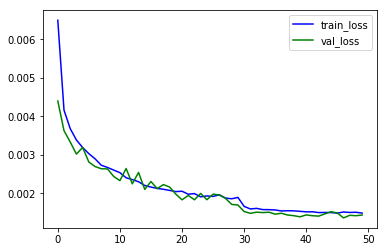

In [0]:
plt.figure()
plt.plot(trends['train_loss'],color='b',label='train_loss')
plt.plot(trends['val_loss'],color='g',label='val_loss')
plt.legend()
plt.show()

In [0]:
iter_val_loader = iter(val_loader)
inputs, masks, contexts = next(iter_val_loader)
if use_cuda:
    inputs, masks, contexts = inputs.cuda(), masks.cuda(), contexts.cuda()
#         inputs = Variable(inputs)
#         masks = Variable(masks)
#         contexts = Variable(contexts)
outputs = tanh(net(inputs))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


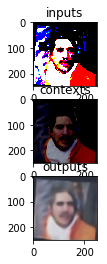

In [0]:
f,ax = plt.subplots(3)
for i,(t,n) in enumerate(zip([inputs,contexts,outputs],['inputs','contexts','outputs'])):
    im = t.detach().cpu().numpy()[0]
    im = np.transpose(im,(1,2,0))
    if n == 'outputs':
        im = (im+1)/2.
    else:
        mean_bgr = np.array([104.00698793, 116.66876762, 122.67891434])/255. # because we are reading using cv2
        std_bgr = np.array([0.229, 0.224, 0.225])
        
        im = im * 3*std_bgr[None,None,:]
        
    im = im[:,:,::-1]

    ax[i].imshow(im)
    ax[i].title.set_text(n)
plt.show()

In [0]:
output_im.shape